In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import umap
import numpy as np
import matplotlib.pyplot as plt
from utils import load_data, split_data
import os

print(f"tensorflow: {tf.__version__}")
print(f"keras: {tf.keras.__version__}")

tensorflow: 2.0.0-beta0
keras: 2.2.4-tf


In [2]:
%env DATA_DIR ../data/GSE92742_Broad_LINCS

data_dir = os.environ['DATA_DIR']

# data_fname = 'GSE92742_Broad_LINCS_Level4_ZSPCINF_mlr12k_n1319138x12328.gctx' # Level 4 data
data_fname = 'GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328.gctx' # Level 3 data
data_path = os.path.join(data_dir, data_fname)

sample_meta_fname = 'GSE92742_Broad_LINCS_inst_info.txt'
sample_meta_path = os.path.join(data_dir, sample_meta_fname)

env: DATA_DIR=../data/GSE92742_Broad_LINCS


In [3]:
# Read in raw data, selecting for cells by treatment and cell line

pert_types = [
    'trt_cp',       # treated with compound
    'ctl_vehicle',  # control for compound treatment (e.g DMSO) 
    'ctl_untrt'     # untreated samples
]

cell_ids = [
    'VCAP', # prostate tumor
    'MCF7', # breast tumor
    'PC3',  # prostate tumor
]

# Load Data
sample_meta, gene_labels, data = load_data(data_path, sample_meta_path, pert_types, cell_ids)

# Normalize expression between 0-1 per gene
# TODO: implement this normalization per batch during training
data_normed = data / data.max(0)

print(f"data size: {data.shape}")

data size: (333523, 978)


In [4]:
# Split data into training, validation, and testing
train, val, test = split_data(data_normed, sample_meta, 0.2)

print(f"training size:   {train[0].shape[0]:,}")
print(f"validation size: {val[0].shape[0]:,}")
print(f"testing size:    {test[0].shape[0]:,}")

training size:   213,454
validation size: 53,364
testing size:    66,705


In [5]:
from tensorflow.keras import Sequential, layers
from metrics import PearsonsR

def create_AE(hidden_layers, activation='relu', optimizer='adam', out_size=978):
    model = Sequential()
    model.add(layers.Dense(hidden_layers[0], activation=activation, input_shape=(out_size,)))

    for nunits in hidden_layers[1:]:
        model.add(layers.Dense(nunits, activation=activation))
        
    model.add(layers.Dense(out_size, activation='relu'))
    
    model.compile(
        optimizer = optimizer, 
        loss = 'mean_squared_error',
        metrics = [
            tf.keras.metrics.CosineSimilarity(),
            PearsonsR() # custom correlation metric
        ] 
    )
    
    return model

def create_tf_dataset(X, y, shuffle=True, repeated=True, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X,y))
    if repeated:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(buffer_size = X.shape[0])
    dataset = dataset.batch(batch_size)
    # `prefetch` lets the dataset fetch batches, in the background while the model is training.
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

In [6]:
batch_size = 64
train_dataset = create_tf_dataset(train[0], train[0], batch_size=batch_size)
train_dataset

<PrefetchDataset shapes: ((None, 978), (None, 978)), types: (tf.float32, tf.float32)>

In [7]:
# Tensorboard stuff
# import datetime, os
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tf.random.set_seed(42)
model = create_AE([128, 2, 128])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               125312    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_3 (Dense)              (None, 978)               126162    
Total params: 252,116
Trainable params: 252,116
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.fit(
    train_dataset,
    epochs = 5,
    shuffle = True,
    steps_per_epoch = train[0].shape[0] // batch_size,
    validation_data = (val[0], val[0]),
#     callbacks = [tensorboard_callback]
)

Epoch 1/5
3335/3335 [==============================] - 13s 4ms/step - loss: 0.1244 - cosine_similarity: 0.8055 - pearsons_corrcoef: 0.2874 - val_loss: 0.1007 - val_cosine_similarity: 0.8467 - val_pearsons_corrcoef: 0.2998
Epoch 2/5
3335/3335 [==============================] - 12s 4ms/step - loss: 0.0923 - cosine_similarity: 0.8602 - pearsons_corrcoef: 0.3676 - val_loss: 0.0778 - val_cosine_similarity: 0.8839 - val_pearsons_corrcoef: 0.3673
Epoch 3/5
3335/3335 [==============================] - 11s 3ms/step - loss: 0.0693 - cosine_similarity: 0.8971 - pearsons_corrcoef: 0.4154 - val_loss: 0.0624 - val_cosine_similarity: 0.9080 - val_pearsons_corrcoef: 0.4289
Epoch 4/5
3335/3335 [==============================] - 11s 3ms/step - loss: 0.0576 - cosine_similarity: 0.9155 - pearsons_corrcoef: 0.4487 - val_loss: 0.0518 - val_cosine_similarity: 0.9243 - val_pearsons_corrcoef: 0.4618
Epoch 5/5
3335/3335 [==============================] - 11s 3ms/step - loss: 0.0482 - cosine_similarity: 0.9298 -

In [9]:
test_loss = model.evaluate(test[0], test[0])
print(f"loss: {test_loss}")

66705/66705 [==============================] - 3s 49us/sample - loss: 0.0450 - cosine_similarity: 0.9346 - pearsons_corrcoef: 0.4877
loss: [0.045035146408469395, 0.9345723, 0.4876899]


### Plotting

In [10]:
from utils import plot_embedding2D, plot_embedding3D
encoder = tf.keras.Model(inputs=model.layers[0].input, outputs=model.layers[1].output)
h = encoder.predict(test[0])

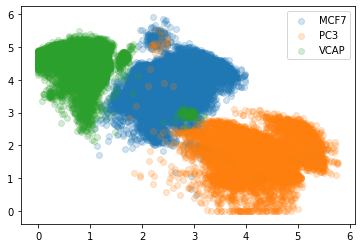

In [11]:
plot_embedding2D(h, test[1].cell_id.values, alpha=0.2)

In [12]:
import pandas as pd
cell_info_fname = 'GSE92742_Broad_LINCS_cell_info.txt'
cell_meta = pd.read_csv(os.path.join(data_dir, cell_info_fname), sep='\t', na_values = '-666')

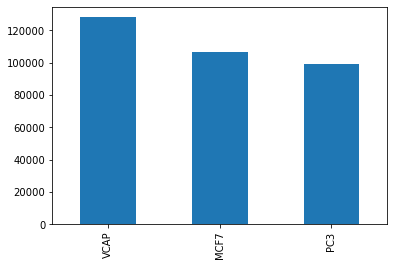

In [13]:
sample_counts = sample_meta['cell_id'].value_counts()
sample_counts[sample_counts > 5000].plot(kind='bar');

In [14]:
cell_meta[cell_meta.base_cell_id == 'PC3']

,cell_id,cell_type,base_cell_id,precursor_cell_id,modification,sample_type,primary_site,subtype,original_growth_pattern,provider_catalog_id,original_source_vendor,donor_age,donor_sex,donor_ethnicity
54,PC3,cell line,PC3,NaN,NaN,tumor,prostate,adenocarcinoma,mix,CRL-1435,ATCC,62.0,M,Caucasian
55,PC3.101,cell line,PC3,PC3,genetically modified to stably express Cas9 pr...,tumor,prostate,adenocarcinoma,mix,CRL-1435,ATCC,62.0,M,Caucasian
56,PC3.311,cell line,PC3,PC3,genetically modified to stably express Cas9 pr...,tumor,prostate,adenocarcinoma,mix,CRL-1435,ATCC,62.0,M,Caucasian
